This example will show how to generate the trajectory analysis from [1] using the MindScoPy package

In [1]:
import mindscopy as ms
from mindscopy.preprocessing.artifact_removal import peak_rejection, riemannian_potato_rejection
from mindscopy.preprocessing.misc import epoch
from mindscopy.preprocessing.rebias import apply_rebias_to_groups
from mindscopy.preprocessing.feature_extraction import ScaledTangentSpace
import numpy as np
import pyriemann
import pickle

In [2]:
# load the preprocessed (bandpass filtered and epoched) BCI Competition IV 2a data
with open('data/BCI_Comp_IV_2a/preprocessed_data.pkl', 'rb') as f:
    d = pickle.load(f)


In [3]:
# select data from one person
p = 3

# Extract all data from both sessions
X = np.concatenate([d[p][1]['trials'], d[p][2]['trials']])
y = np.concatenate([d[p][1]['labels'], d[p][2]['labels']])
blocks = np.concatenate([
    d[p][1]['run_labels'], 
    d[p][2]['run_labels']+(1+max(d[p][1]['run_labels'])) # shift the second session's block labels
])

Perform the preprocessing steps of artifact rejecting and sub-epoching.

In [4]:
print(X.shape)

(543, 22, 1501)


In [5]:
# apply peak rejection
X, rejected_trials = peak_rejection(X, threshold=350, verbose=True)
y = np.delete(y, rejected_trials)
blocks = np.delete(blocks, rejected_trials)

0 trials rejected.


In [6]:
# apply riemannian potato rejection to each block of trials
clean_X = []
clean_y = []
clean_blocks = []
for block in np.unique(blocks):
    block_idx = blocks == block
    X_block = X[block_idx]
    y_block = y[block_idx]
    blocks_block = blocks[block_idx]

    X_block, rejected_trials = riemannian_potato_rejection(X_block, threshold=2.5, verbose=True)
    y_block = np.delete(y_block, rejected_trials)
    blocks_block = np.delete(blocks_block, rejected_trials)

    clean_X.append(X_block)
    clean_y.append(y_block)
    clean_blocks.append(blocks_block)

X = np.concatenate(clean_X)
y = np.concatenate(clean_y)
blocks = np.concatenate(clean_blocks)

Iteration 0: 2 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 2 total trials rejected.
Iteration 0: 0 trials rejected.
Process complete, 0 total trials rejected.
Iteration 0: 2 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 2 total trials rejected.
Iteration 0: 2 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 2 total trials rejected.
Iteration 0: 2 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 2 total trials rejected.
Iteration 0: 2 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 2 total trials rejected.
Iteration 0: 0 trials rejected.
Process complete, 0 total trials rejected.
Iteration 0: 1 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 1 total trials rejected.
Iteration 0: 1 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 1 total trials rejected.
Iteration 0: 3 trials rejected.
Iteration 1: 0 trials rejected.
Process complete, 3 total trials reje

Now compute the mean covariance matrix for each block. These will be used for rebiasing the sub-epoch covariance matrices.

In [7]:
Nt, Nc, Ns = X.shape
Nblks = len(np.unique(blocks))

# block means
block_means = np.zeros((Nblks, Nc, Nc))
for i, block in enumerate(np.sort(np.unique(blocks))):
    block_covs = pyriemann.utils.covariance.covariances(X[blocks == block])
    block_means[i] = pyriemann.utils.mean.mean_covariance(block_covs)

In [8]:
# Generate sub-epochs for each trial
Fs = 250
length = 2
stride_cluster = 1
stride_traj = 0.5
Ns_epoch = int(Fs * length)
Xcluster = epoch(X, Ns_epoch, int(Fs * stride_cluster))
Xtraj = epoch(X, Ns_epoch, int(Fs * stride_traj))

In [9]:
Nclust_epochs = Xcluster.shape[1]
Ntraj_epochs = Xtraj.shape[1]

In [10]:
# apply the rebiasing to the sub-epochs
blocks_clust_epochs = np.repeat(blocks, Xcluster.shape[1])
blocks_traj_epochs = np.repeat(blocks, Xtraj.shape[1])

Xcluster = np.reshape(Xcluster, (-1, Nc, Ns_epoch))
Xtraj = np.reshape(Xtraj, (-1, Nc, Ns_epoch))

Xclust_covs = pyriemann.utils.covariance.covariances(Xcluster)
Xtraj_covs = pyriemann.utils.covariance.covariances(Xtraj)


Xclust_covs = apply_rebias_to_groups(Xclust_covs, blocks_clust_epochs, block_means)
Xtraj_covs = apply_rebias_to_groups(Xtraj_covs, blocks_traj_epochs, block_means)

In [11]:
# apply feature extraction
feature_extractor = ScaledTangentSpace().fit(Xclust_covs)
Xclust_features = feature_extractor.transform(Xclust_covs)
Xtraj_features = feature_extractor.transform(Xtraj_covs)

In [12]:
# put the data back into trial, epoch, format
Xclust_features = np.reshape(Xclust_features, (Nt, Nclust_epochs, -1))
Xtraj_features = np.reshape(Xtraj_features, (Nt, Ntraj_epochs, -1))

print(Xclust_features.shape)
print(Xtraj_features.shape)

(523, 5, 253)
(523, 9, 253)


In [13]:
# Perform clustering and generate the trajectory sub-space
np.random.seed(42)
subspace = ms.Trajectory_Subspace(krange=range(2,12)).fit(Xclust_features, y=y, verbose=True)

Selecting the number of clusters using prediction strength.
Number of clusters selected: 6
Singular values: [8.00424438e+00 5.11398519e+00 3.81604102e+00 3.09047410e+00
 1.32124691e+00 7.40050590e-16]
w shape: (253, 6), U shape: (253, 6)


In [14]:
chs = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'P1', 'Pz', 'P2', 'POz']
ch_map = {
    ch : i for _, ch in enumerate(chs)
}

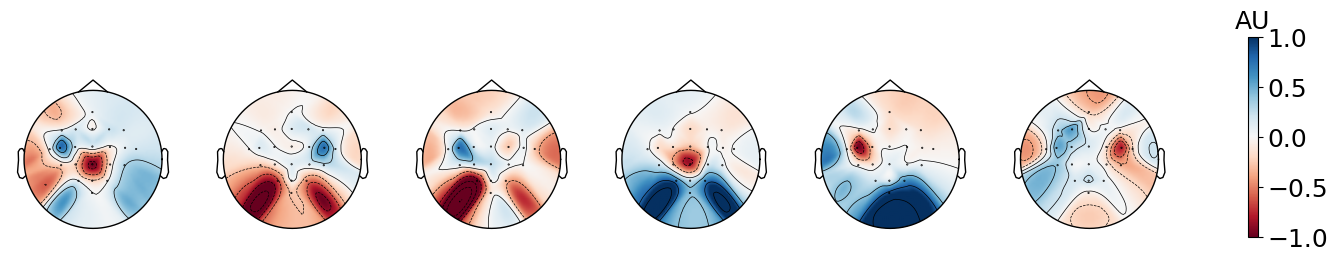

In [15]:
# visulize the pattern state activation patterns
subspace.plot_state_activation_patterns(np.reshape(Xclust_features, (-1, Xclust_features.shape[-1])), Xclust_covs, list(ch_map.keys()))

In [16]:
print(subspace.clustering_model.cluster_centers_.shape)

(6, 253)


In [17]:
# select a block and task to analyze
block = 4
task = 3

X_blk = Xtraj_features[blocks == block]
y_blk = y[blocks == block]

X_task = X_blk[y_blk == task]

In [18]:
Traj_all_tasks = ms.Trajectory(subspace)
Traj_all_tasks.fit(X_blk)

Traj_task = ms.Trajectory(subspace)
Traj_task.fit(X_task)

In [19]:
# compute the InterTaskDiff
InterTaskDiff = Traj_task.InterTaskDiff(Traj_all_tasks)
print(np.log(InterTaskDiff))

[-3.63115043 -3.89200612 -4.33552844 -3.00805605 -2.51721361 -2.35534878
 -2.28975852 -2.17484928 -2.13309866]


In [20]:
# Computer InterTrialVar
InterTrialVar = Traj_task.InterTrialVar(Traj_all_tasks)
print(InterTrialVar)

[1.1013685  0.95676357 1.0504191  0.97041974 0.759702   0.62285826
 0.55438719 0.51490235 0.56596011]


In [21]:
# Compute IntraTrialVar
IntraTrialVar = Traj_task.IntraTrialVar()
print(IntraTrialVar)

0.24704099564204027


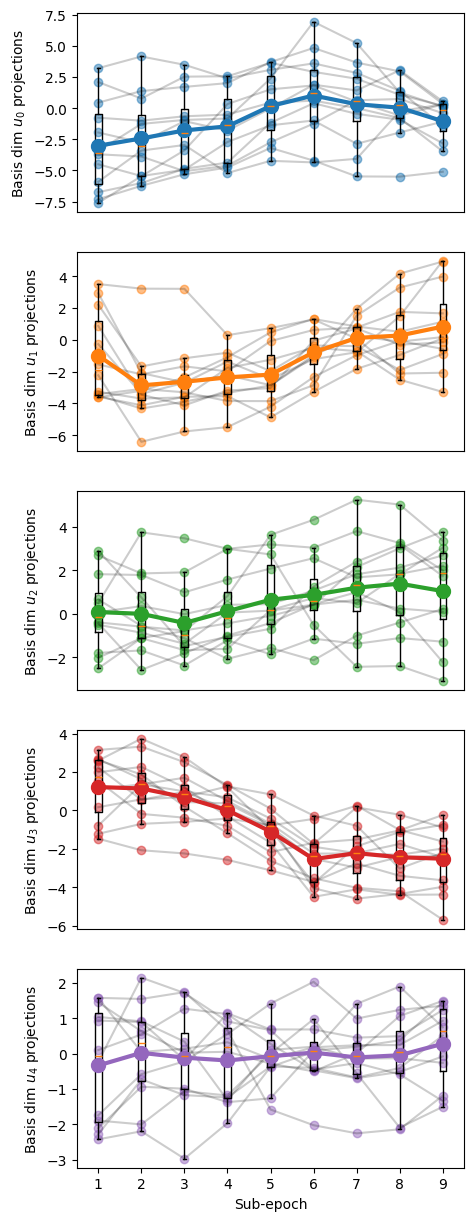

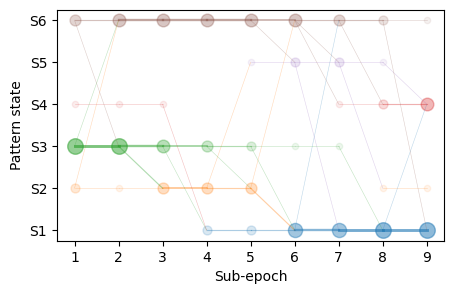

In [22]:
# visualize the trajectory
Traj_task.plot()